In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from joblib import dump, load
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
param_sets = [
    {
        'learning_rate': 0.2,
        'n_estimators': 1000,
        'max_depth': 5,
        'min_child_weight': 1,
        'subsample': 1,
        'colsample_bytree': 1,
        'eval_metric': 'logloss',
        'random_state': 42
    },
    {
        'learning_rate': 0.01,
        'n_estimators': 5000,
        'max_depth': 4,
        'min_child_weight': 6,
        'gamma': 0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.005,
        'eval_metric': 'logloss',
        'random_state': 42
    },
    {
        'learning_rate': 0.01,
        'n_estimators': 1000,
        'max_depth': 4,
        'min_child_weight': 1,
        'gamma': 10,
        'subsample': 1.0,
        'colsample_bytree': 0.4,
        'reg_alpha': 0.3,
        'eval_metric': 'logloss',
        'random_state': 42
    },
    {
        'learning_rate': 0.1,
        'n_estimators': 500,
        'max_depth': 10,
        'min_child_weight': 1,
        'gamma': 10,
        'subsample': 0.8,
        'colsample_bytree': 0.4,
        'reg_alpha': 0.3,
        'eval_metric': 'logloss',
        'random_state': 42
    }
]

# Đọc dữ liệu train
train_data = pd.read_csv('R2G_output/undersampled_train.csv')
X_train = train_data.drop('Label', axis=1)
y_train = train_data['Label']

# Khởi tạo KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Khởi tạo biến lưu metrics
all_cv_metrics = []

# Đánh giá từng bộ tham số
for i, params in enumerate(param_sets, 1):
    print(f"Đang đánh giá Param Set {i}...")
    fold_metrics = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        
        # Train và đo thời gian
        start_time = time.time()
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        end_time = time.time()
        
        # Tính metrics (không bao gồm model size)
        metrics = [
            accuracy_score(y_val, y_pred),
            precision_score(y_val, y_pred),
            recall_score(y_val, y_pred),
            f1_score(y_val, y_pred),
            roc_auc_score(y_val, y_pred),
            end_time - start_time
        ]
        
        # Tính model size riêng
        temp_path = f'temp_model_fold_{i}.joblib'
        dump(model, temp_path)
        model_size = os.path.getsize(temp_path) / 1024
        os.remove(temp_path)
        
        # Thêm model size vào metrics
        metrics.append(model_size)
        fold_metrics.append(metrics)
    
    avg_metrics = np.mean(fold_metrics, axis=0)
    all_cv_metrics.append(avg_metrics)
    print(f"Param Set {i} - CV Metrics:", avg_metrics)

# Gán vào các biến riêng
metrics_cv1, metrics_cv2, metrics_cv3, metrics_cv4 = all_cv_metrics

Đang đánh giá Param Set 1...
Param Set 1 - CV Metrics: [9.71859097e-01 9.95499849e-01 9.19734999e-01 9.56118636e-01
 9.58828067e-01 2.15028361e+01 2.51604453e+03]
Đang đánh giá Param Set 2...
Param Set 2 - CV Metrics: [9.71385185e-01 9.96630850e-01 9.17256386e-01 9.55297519e-01
 9.57852979e-01 1.27800611e+02 8.09457949e+03]
Đang đánh giá Param Set 3...
Param Set 3 - CV Metrics: [9.68111481e-01 9.89722681e-01 9.13823664e-01 9.50259837e-01
 9.54539521e-01 2.28794349e+01 1.63368262e+03]
Đang đánh giá Param Set 4...
Param Set 4 - CV Metrics: [9.71658910e-01 9.96818938e-01 9.17905973e-01 9.55736132e-01
 9.58220670e-01 1.17898209e+01 1.18916855e+03]


In [3]:
# Đọc dữ liệu test
test_data = pd.read_csv('R2G_output/undersampled_test.csv')
X_test = test_data.drop('Label', axis=1)
y_test = test_data['Label']

# Đánh giá từng bộ tham số
all_test_metrics = []
for i, params in enumerate(param_sets, 1):
    print(f"Đang đánh giá Param Set {i} trên test set...")
    model = xgb.XGBClassifier(**params)
    
    # Train và đo thời gian
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    # Tính metrics (không bao gồm model size)
    metrics = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred),
        end_time - start_time
    ]
    
    # Tính model size riêng và lưu model
    model_path = f'xgboost_model_undersampled{i}.joblib'
    dump(model, model_path)
    model_size = os.path.getsize(model_path) / 1024
    
    # Thêm model size vào metrics
    metrics.append(model_size)
    all_test_metrics.append(metrics)
    print(f"Param Set {i} - Test Metrics:", metrics)

# Gán vào các biến riêng
metrics_test1, metrics_test2, metrics_test3, metrics_test4 = all_test_metrics


Đang đánh giá Param Set 1 trên test set...
Param Set 1 - Test Metrics: [0.9717374853238064, 0.9955769199353078, 0.9192967503742896, 0.9559175014362153, np.float64(0.9586273263069044), 27.896246194839478, 2539.314453125]
Đang đánh giá Param Set 2 trên test set...
Param Set 2 - Test Metrics: [0.9712673443066425, 0.9964351859439792, 0.9170830677794162, 0.9551137914579328, np.float64(0.957721300717216), 157.4527702331543, 8112.6962890625]
Đang đánh giá Param Set 3 trên test set...
Param Set 3 - Test Metrics: [0.9679436735863715, 0.9897380358821366, 0.9133005743506971, 0.9499842113211692, np.float64(0.9542829245361211), 27.07260489463806, 1641.9580078125]
Đang đánh giá Param Set 4 trên test set...
Param Set 4 - Test Metrics: [0.9715350984153482, 0.9966497515983306, 0.9176902277415535, 0.9555415938585986, np.float64(0.958073906129284), 13.303964376449585, 1294.099609375]


In [4]:
# Tạo báo cáo Excel
report_data = []
metric_names = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 (%)', 'AUC (%)', 'Exec Time (s)', 'Model Size (KB)']

for i in range(4):
    # Chuẩn bị dữ liệu CV (7 metrics)
    cv_metrics = [
        all_cv_metrics[i][0] * 100,  # accuracy
        all_cv_metrics[i][1] * 100,  # precision
        all_cv_metrics[i][2] * 100,  # recall
        all_cv_metrics[i][3] * 100,  # f1
        all_cv_metrics[i][4] * 100,  # auc
        all_cv_metrics[i][5],        # exec_time
        all_cv_metrics[i][6]         # model_size
    ]
    
    # Chuẩn bị dữ liệu Test (7 metrics)
    test_metrics = [
        all_test_metrics[i][0] * 100,
        all_test_metrics[i][1] * 100,
        all_test_metrics[i][2] * 100,
        all_test_metrics[i][3] * 100,
        all_test_metrics[i][4] * 100,
        all_test_metrics[i][5],
        all_test_metrics[i][6]
    ]
    
    # Thêm vào báo cáo
    report_data.append([f'Param Set {i+1} (CV)'] + cv_metrics)
    report_data.append([f'Param Set {i+1} (Test)'] + test_metrics)

# Tạo DataFrame
report_df = pd.DataFrame(report_data, columns=['Model'] + metric_names)
report_df.to_excel('xgboost_undersampled_report.xlsx', index=False)

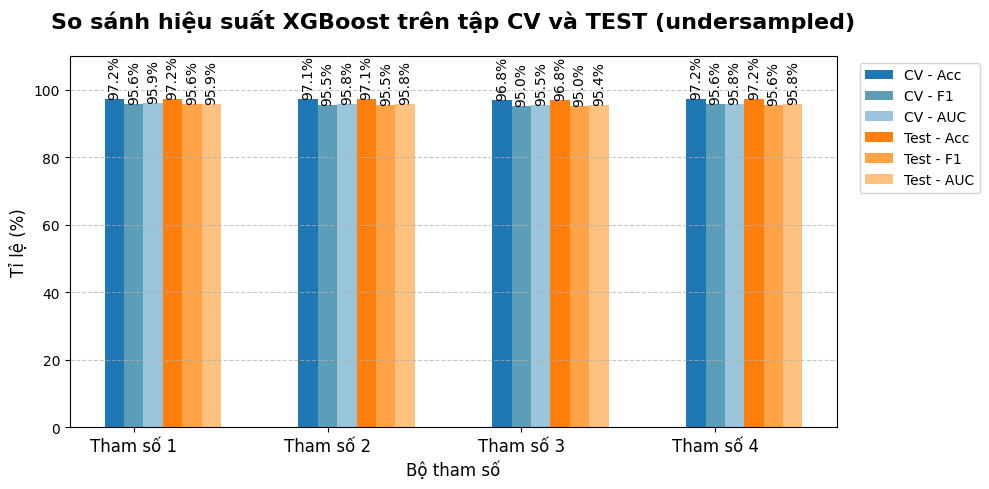

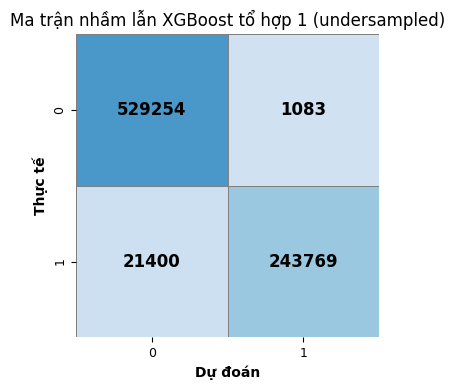

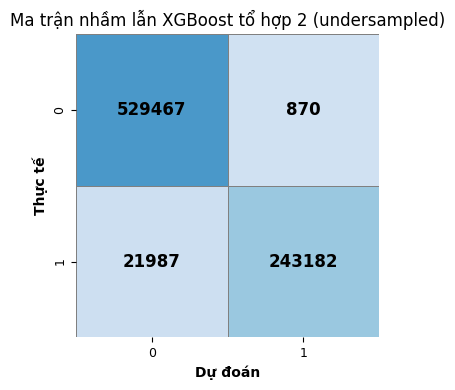

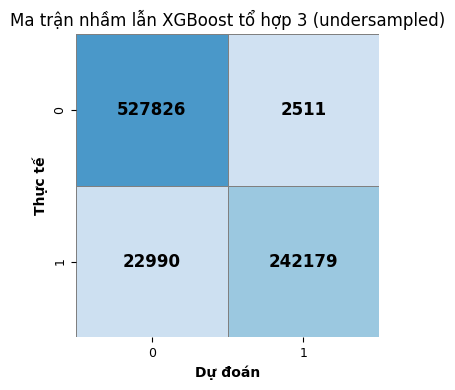

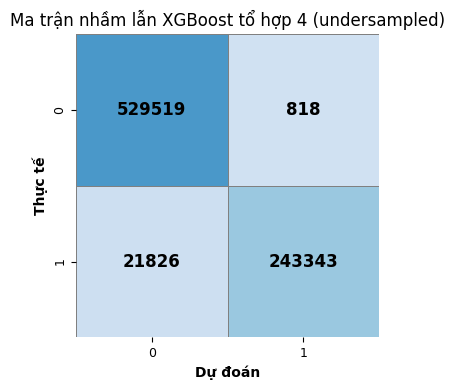

In [5]:
# 1. Vẽ biểu đồ so sánh CV vs Test
labels = ['Acc', 'F1', 'AUC'] * 2  # Nhãn cho 6 cột
colors = ['#1f77b4', '#5c9eb7', '#9ac5db', '#ff7f0e', '#ffa347', '#ffc17f']  # Xanh nhạt dần -> cam nhạt dần

# Tạo mảng giá trị cho từng param set
data = []
for i in range(len(param_sets)):
    # Thêm 3 giá trị CV (acc, f1, auc)
    data.extend([all_cv_metrics[i][0]*100, all_cv_metrics[i][3]*100, all_cv_metrics[i][4]*100])
    # Thêm 3 giá trị Test (acc, f1, auc)
    data.extend([all_test_metrics[i][0]*100, all_test_metrics[i][3]*100, all_test_metrics[i][4]*100])

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
x = np.arange(len(param_sets))  
width = 0.10  

# Vẽ từng cột
bars = []
for i in range(6): 
    bar_pos = x + (i * width) - (1 * width)  
    bars.append(plt.bar(bar_pos, 
                       [data[j*6 + i] for j in range(len(param_sets))], 
                       width, 
                       color=colors[i]))

# Cấu hình trục và nhãn
plt.title('So sánh hiệu suất XGBoost trên tập CV và TEST (undersampled)', fontsize=16, fontweight='bold', pad=20) # điều chỉnh ở đây
plt.xlabel('Bộ tham số', fontsize=12)
plt.ylabel('Tỉ lệ (%)', fontsize=12)
plt.xticks(x, [f'Tham số {i+1}' for i in range(len(param_sets))], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm chú thích
legend_labels = ['CV - Acc', 'CV - F1', 'CV - AUC', 'Test - Acc', 'Test - F1', 'Test - AUC']
plt.legend(bars, legend_labels, fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left')

# Thêm giá trị trên mỗi cột (xoay dọc)
for bar in bars:
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', rotation=90, fontsize=10)

plt.tight_layout()
plt.ylim(0, 110)
plt.show()


# 2. Vẽ ma trận nhầm lẫn cho từng bộ tham số
from matplotlib.colors import LinearSegmentedColormap
light_blues = LinearSegmentedColormap.from_list(
    'light_blues', 
    plt.cm.Blues(np.linspace(0.2, 0.6))
)
for i in range(1, 5):  
    model_path = f'xgboost_model_undersampled{i}.joblib'
    model = load(model_path)  
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Thiết lập kích thước và font
    plt.figure(figsize=(4, 4), dpi=100)
   
    
    # Vẽ ma trận nhầm lẫn
    ax = sns.heatmap(cm, 
                    annot=True, 
                    fmt='d', 
                    cmap=light_blues,
                    annot_kws={'size': 12, 'color': 'black', 'weight': 'bold'},
                    cbar=False,
                    square=True,
                    linewidths=0.5,
                    linecolor='gray')
    
    plt.title(f'Ma trận nhầm lẫn XGBoost tổ hợp {i} (undersampled)')
    ax.set_xlabel('Dự đoán', fontsize=10, fontweight='bold')
    ax.set_ylabel('Thực tế', fontsize=10, fontweight='bold')
    
    # Điều chỉnh font cho số trên trục
    ax.tick_params(axis='both', 
                  which='major', 
                  labelsize=9,
                  labelcolor='black')
    
    plt.tight_layout()
    plt.show()